<a href="https://colab.research.google.com/github/Vineet-Mehta/Chemoinformatics/blob/master/zabr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install py_vollib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 4.6 MB/s eta 0:00:00
  Created wheel for py_vollib: filename=py_vollib-1.0.1-py3-none-any.whl size=62829 sha256=bdcff36a2cab60b7faadb03db906afff28931ab1f32de59615d6360df3aca6ad
  Stored in directory: /root/.cache/pip/wheels/84/0c/fc/b68506eda40cccaeb0013be550ba904d253ec90eae2b156052
  Created wheel for py_lets_be_rational: filename=py_lets_be_rational-1.0.1-py3-none-any.whl size=24450 sha256=31e08500214aadb5f93469d39fe1dccab4a8fdba8c5d123e0c175d016f8195b4
  Stored in directory: /root/.cache/pip/wheels/32/d9/4f/360d4b0b9ec7c65583ec7c8e72fd2158c97ad04fbcb932891c
Successfully built py_vollib py_lets_be_rational


<ipython-input-56-f6208bb6ba54>:88: RuntimeWarning: invalid value encountered in true_divide
  nu[:, j] = (S - K) / x
<ipython-input-56-f6208bb6ba54>:124: RuntimeWarning: invalid value encountered in true_divide
  nubar[:, j] = np.log(S / K) / x
<ipython-input-56-f6208bb6ba54>:52: RuntimeWarning: invalid value encountered in sqrt
  return 0.5 * (-B(y) * f + np.sqrt(B(y)**2 * f**2 - 4 * A(y) * (C * f**2 - 1))) / A(y)


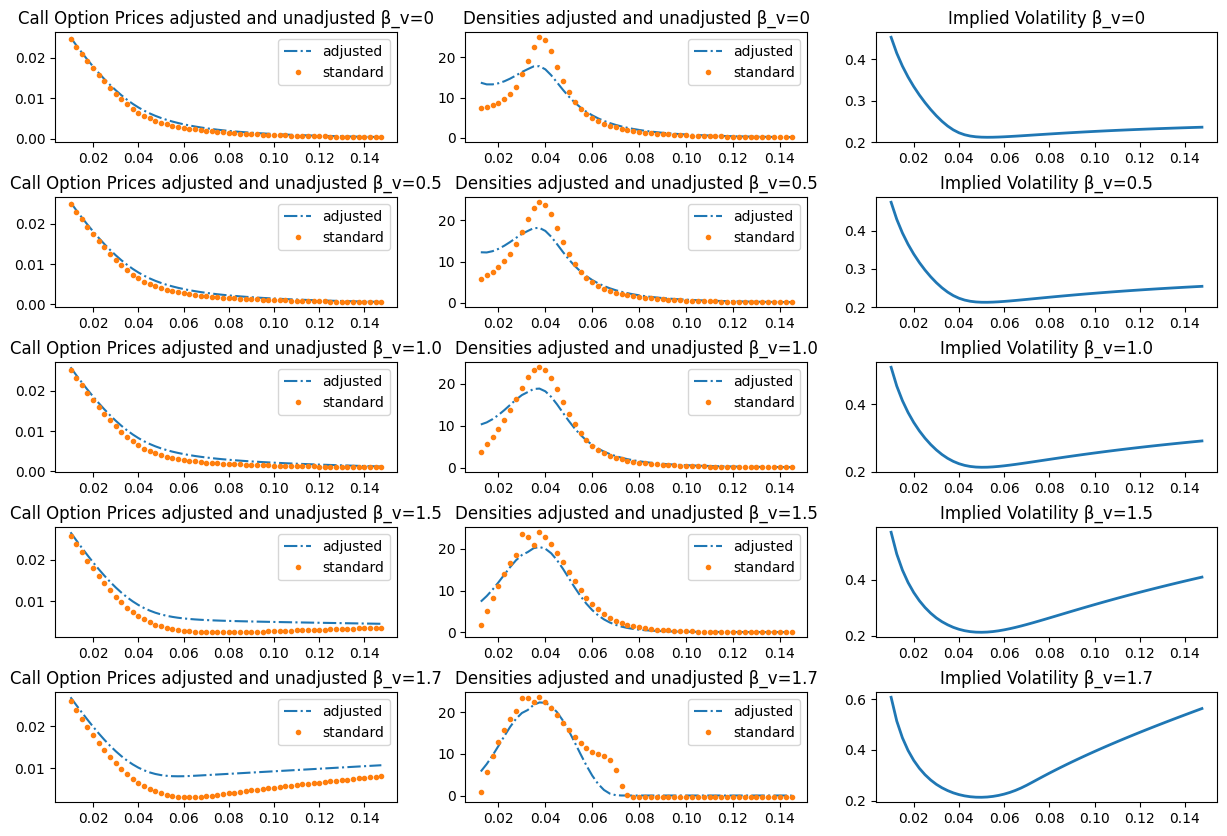

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp
from py_vollib.black_scholes.implied_volatility import implied_volatility
from scipy.stats import norm

def bls_price(S, K, r, T, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

def RNDensity(K, C):
    delta = K[1:] - K[:-1]
    dC = (C[1:] - C[:-1]) / delta
    
    delta2 = K[2:] - K[1:-1]
    dC2 = (dC[1:] - dC[:-1]) / delta2
    
    out2 = dC2
    out1 = K[1:-1]
    
    return out1, out2

alpha = 0.0873
beta = 0.7
rho = -0.48
epsi = 0.47
S = 0.0325
T = 10
Kl = 0.01
Ku = 0.15
delta = 0.0025
K = np.concatenate((np.arange(Kl, S-delta, delta), [S], np.arange(S+delta, Ku, delta)))
sigS = lambda S: alpha * S**beta
gamma = [0,0.5, 1.0, 1.5, 1.7]

nG = len(gamma)
nK = len(K)

nubar = np.zeros((nK, nG))
nu = np.zeros((nK, nG))
impvol = np.zeros((nK, nG))
callMat = np.zeros((nK, nG))
callnubar = np.zeros((nK, nG))

fig, axs = plt.subplots(nG, 3, figsize=(15, 10))
fig.subplots_adjust(hspace=0.5)

#F(y, f) or df / dy;
def F(y, f):
    return 0.5 * (-B(y) * f + np.sqrt(B(y)**2 * f**2 - 4 * A(y) * (C * f**2 - 1))) / A(y)

options = {'rtol': 1e-4, 'atol': 1e-6}

fy = np.zeros_like(K)
lognormalvolv = np.zeros((nG, nK))

#fig, axs = plt.subplots(nG, 3, figsize=(16, 10))
for j in range(nG):
  # For our case, adjepsi is the actual VoVol. d(alpha) = adjepsi * alpha**gamma
  #epsi is the initial Vol. basically alpha(0)
    if abs(gamma[j] - 1.0) < 1e-06:
        adjepsi = epsi
    else:
        adjepsi = epsi * alpha**(1 - gamma[j])

    y = (S**(1-beta) - K**(1-beta)) / (1 - beta) * alpha**(gamma[j] - 2)

    # Below do not assume any y
    A = lambda y: 1 + (gamma[j] - 2)**2 * adjepsi**2 * y**2 + 2 * rho * (gamma[j] - 2) * adjepsi * y
    B = lambda y: 2 * rho * (1 - gamma[j]) * adjepsi + 2 * (1 - gamma[j]) * (gamma[j] - 2) * adjepsi**2 * y
    C = (1 - gamma[j])**2 * adjepsi**2

    f0 = 0
    y0 = 0
    fy = np.zeros_like(K)
    for i in range(nK):
        if np.isclose(K[i], S):
            fy[i] = 0 # coz y itself  =0 
        else:
            fy[i] = solve_ivp(F, [y0, y[i]], [f0], atol = 1e-6, rtol = 1e-4).y[-1][-1]
            f0 = fy[i]
            y0 = y[i]
            
    x = alpha**(1 - gamma[j]) * fy
    # Implied normal volatility
    nu[:, j] = (S - K) / x
    for i in range(nK):
      # apply l'hopital rule
      if np.isclose(K[i],S): 
        nu[i, j] = sigS(K[i])
    # Transfer the implied normal vols to implied Black vols
    c1 = nu[:, j] * np.sqrt(T)
    c2 = (S - K) / c1
    callBachelier = (S - K) * norm.cdf(c2) + c1 * norm.pdf(c2)
    impvol[:, j] = [implied_volatility(callBachelier[i], S, K[i], T, 0,'c') for i in range(nK)]

    #Nu(k) = SigS(k) / F(y, f(y))
    phi = sigS(K)/F(y,fy)
    
    eta = np.abs(x) / np.sqrt(T)
    Px2 = 2 * (1 - eta * (norm.cdf(-eta) / norm.pdf(eta)))
    #If not this, can use approximate also.
    theta2 = phi**2*Px2

    callMat[0, j] = callBachelier[0]
    callMat[-1, j] = callBachelier[-1]

    diagonal = -2 * np.diag(theta2[1:-1])
    diagonal_lower = np.diag(theta2[2:-1], k=-1)
    diagonal_upper = np.diag(theta2[1:-2], k=1)
    lhs = np.eye(len(theta2[1:-1])) - 0.5 * T * (diagonal_lower + diagonal + diagonal_upper) / delta**2

    rhs = np.maximum(S - K[1:-1], 0)
    BoundaryCond = np.zeros_like(rhs)
    BoundaryCond[-1] = (theta2[-2] / delta**2) * callBachelier[-1]
    BoundaryCond[0] = (theta2[1] / delta**2) * callBachelier[0]
    rhs = rhs + 0.5 * T * BoundaryCond
    callMat[1:-1, j] = np.linalg.solve(lhs, rhs)
    callMat[0, j] = callBachelier[0]
     #Implied lognormal volatility
    nubar[:, j] = np.log(S / K) / x
    for i in range(nK):
      # apply l'hopital rule
      if np.isclose(K[i],S): 
        nubar[i, j] = sigS(K[i]) / K[i]
    callnubar[:, j] = [bls_price(S, K[i], 0, T, nubar[i, j]) for i in range(nK)]

    for i in range(nK):
      lognormalvolv[j, i] = implied_volatility(callMat[i, j], S, K[i], T, 0, 'c')

    axs[j, 0].plot(K, callMat[:, j], '-.', K, callnubar[:, j], '.')
    axs[j, 0].set_title('Call Option Prices adjusted and unadjusted β_v=' + str(gamma[j]))
    axs[j, 0].legend(['adjusted', 'standard'])

    a, b = RNDensity(K, callMat[:, j])
    aa, bb = RNDensity(K, callnubar[:, j])

    axs[j, 1].plot(a, b, '-.', aa, bb, '.')
    axs[j, 1].set_title('Densities adjusted and unadjusted β_v=' + str(gamma[j]))
    axs[j, 1].legend(['adjusted', 'standard',])

    axs[j, 2].plot(K, impvol[:, j], linewidth=2)
    axs[j, 2].set_title('Implied Volatility β_v=' + str(gamma[j]))

plt.show()